# Starbucks Capstone Challenge

### Introduction

This project analyses customer behaviour on the Starbucks Rewards mobile app using simulated data. The main objective is to identify which demographic groups respond best to different types of offers (such as discounts, BOGO, and informational offers) and to develop data-driven strategies for targeted marketing. By combining transaction records, customer demographics, and offer metadata, the project explores customer engagement, predicts offer completion, and segments customers to optimise offer targeting and maximise business value.

Key steps in this project include:
- Data cleaning and preprocessing of customer, offer, and transaction data.
- Exploratory data analysis to uncover trends in demographics, spending, and offer response.
- Feature engineering to create meaningful variables for modelling.
- Predictive modelling to classify offer responders and regress total spend.
- Customer segmentation using clustering to inform targeted marketing strategies.

The findings and models from this project can help Starbucks and similar businesses deliver more effective, personalised offers to their customers, improving engagement and return on marketing investment.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning

Let's inspect the data and see if there are any problems.

In [2]:
# Inspect the dataframes
print("Portfolio shape:", portfolio.shape)
display(portfolio.head())

print("Profile shape:", profile.shape)
display(profile.head())

print("Transcript shape:", transcript.shape)
display(transcript.head())

# Check for missing values
print("\nMissing values in portfolio:\n", portfolio.isnull().sum())
print("\nMissing values in profile:\n", profile.isnull().sum())
print("\nMissing values in transcript:\n", transcript.isnull().sum())

Portfolio shape: (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Profile shape: (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Transcript shape: (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0



Missing values in portfolio:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Missing values in profile:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Missing values in transcript:
 person    0
event     0
value     0
time      0
dtype: int64


### Data Observations

- **Portfolio Data**
  - Contains 10 unique offers, each with details such as reward, channels, difficulty, duration, and offer type.
  - No missing values detected; data appears clean and ready for analysis.

- **Profile Data**
  - Contains 17,000 customer records with demographic information.
  - 2,175 entries have missing values for both `gender` and `income`.
  - Many entries have `age` recorded as 118, which likely indicates missing or invalid data.
  - The `became_member_on` field is in integer date format and should be converted to a datetime type for analysis.

- **Transcript Data**
  - Contains over 300,000 records of customer events (transactions, offers received/viewed/completed).
  - No missing values detected.
  - The `value` column is a dictionary that contains different keys depending on the event type (e.g., `offer id`, `amount`, `reward`). This column will need to be expanded for easier analysis.

In [3]:
# Clean profile data
profile_clean = profile[(profile['age'] != 118) & (profile['gender'].notnull()) & (profile['income'].notnull())].copy()
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')

print("Profile cleaned shape:", profile_clean.shape)
display(profile_clean.head())

# Expand transcript 'value' column
def extract_value(row):
    if 'offer id' in row:
        return row.get('offer id')
    elif 'offer_id' in row:
        return row.get('offer_id')
    elif 'amount' in row:
        return row.get('amount')
    elif 'reward' in row:
        return row.get('reward')
    else:
        return None

transcript_expanded = transcript.copy()
transcript_expanded['offer_id'] = transcript_expanded['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
transcript_expanded['amount'] = transcript_expanded['value'].apply(lambda x: x.get('amount'))
transcript_expanded['reward'] = transcript_expanded['value'].apply(lambda x: x.get('reward'))

display(transcript_expanded.head())

Profile cleaned shape: (14825, 5)


,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [13]:
# Create 'plots' directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

def plot_histogram(data, column, bins=30, kde=True, title='', xlabel='', ylabel='Count', figsize=(6,5), filename=None):
    """
    Plots a histogram for a specified column in a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to plot.
        bins (int): Number of bins for the histogram (default: 30).
        kde (bool): Whether to plot a kernel density estimate (default: True).
        title (str): Plot title.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis (default: 'Count').
        figsize (tuple): Figure size (default: (8,5)).
    """
    plt.figure(figsize=figsize)
    sns.histplot(data[column], bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    if filename:
        plt.savefig(f'plots/{filename}', bbox_inches='tight')
    #plt.close()
    plt.show()

def plot_countplot(data, column, title='', xlabel='', ylabel='Count', figsize=(6,5), filename=None):
    """
    Plots a countplot (bar plot of counts) for a specified column in a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to plot.
        title (str): Plot title.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis (default: 'Count').
        figsize (tuple): Figure size (default: (6,4)).
    """
    plt.figure(figsize=figsize)
    sns.countplot(x=column, data=data)
    plt.title(title)
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    if filename:
        plt.savefig(f'plots/{filename}', bbox_inches='tight')
    #plt.close()
    plt.show()

### Visualisation Insights

- **Age Distribution of Customers**  
  This plot helps us understand the age demographics of Starbucks app users. Identifying age groups with higher representation can guide targeted marketing and offer strategies.

- **Gender Distribution**  
  Visualising gender distribution reveals the balance (or imbalance) between male, female, and other customers. This is important for assessing whether certain offers should be tailored by gender.

- **Income Distribution of Customers**  
  Analysing income distribution provides insight into the purchasing power of the customer base. This can inform which types of offers (e.g., discounts vs. premium rewards) may be most effective for different income segments.

- **Offer Type Distribution**  
  This plot shows the frequency of each offer type (BOGO, discount, informational) in the dataset. Understanding the mix of offers allows us to evaluate which types are most commonly used and later, which are most effective.

- **Distribution of Transaction Amounts**  
  Examining transaction amounts helps us understand typical spending behaviour. This is useful for setting offer thresholds and rewards, and for identifying outliers or unusual spending patterns.

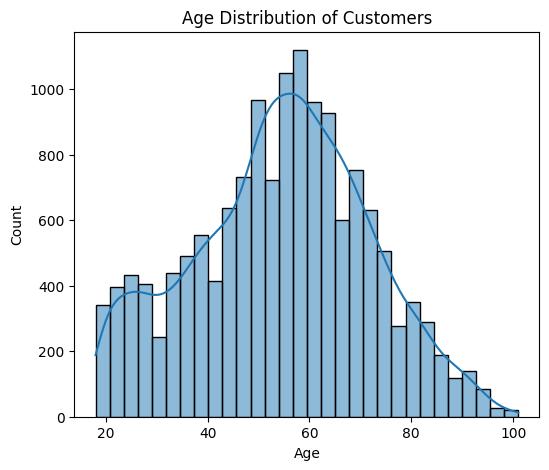

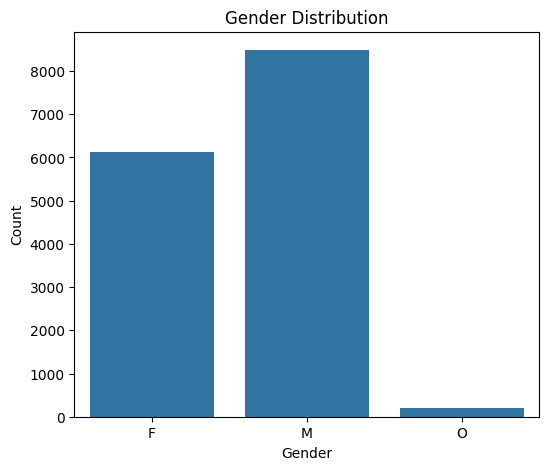

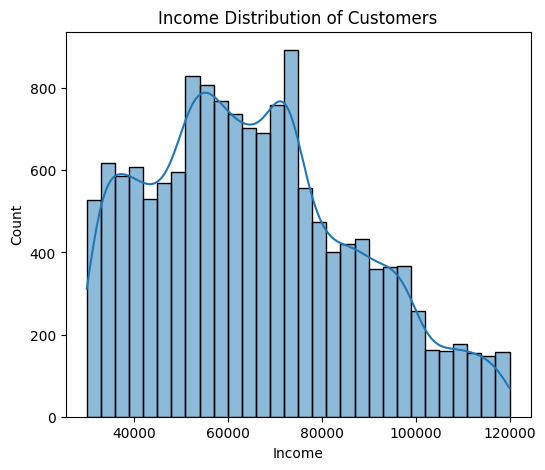

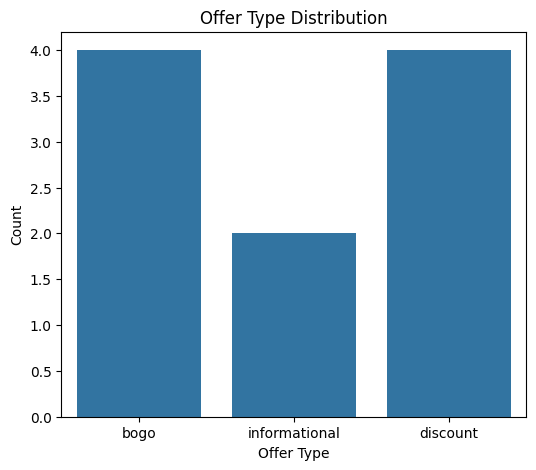

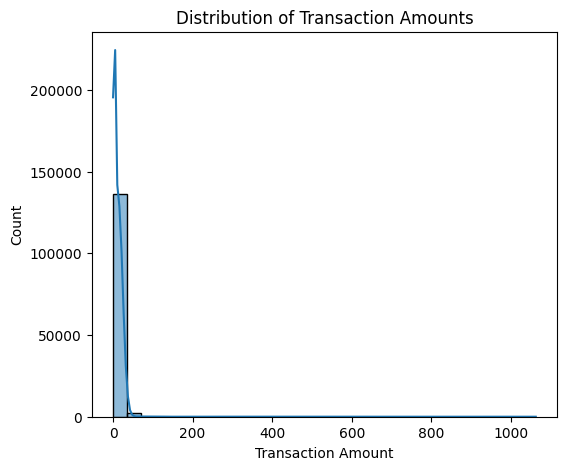

In [19]:

plot_histogram(profile_clean, 'age', title='Age Distribution of Customers', xlabel='Age', filename='age_distribution.png')
plot_countplot(profile_clean, 'gender', title='Gender Distribution', xlabel='Gender', filename='gender_distribution.png')
plot_histogram(profile_clean, 'income', title='Income Distribution of Customers', xlabel='Income', filename='income_distribution.png')
plot_countplot(portfolio, 'offer_type', title='Offer Type Distribution', xlabel='Offer Type', filename='offer_type_distribution.png')
plot_histogram(transcript_expanded.dropna(subset=['amount']), 'amount', title='Distribution of Transaction Amounts', xlabel='Transaction Amount', filename='transaction_amount_distribution.png')

# Deeper Exploratory Data Analysis (EDA) and Feature Engineering

Now that the data is cleaned and we have a basic understanding of the distributions, the next steps are:

1. **Deeper EDA:**  
   - Explore relationships between customer demographics (age, gender, income) and offer response.
   - Investigate which groups are more likely to complete offers or spend more.
   - Analyse offer completion rates by offer type, age group, gender, and income segment.

2. **Feature Engineering:**  
   - Create new features to capture important business concepts and improve model performance, such as:
     - Membership duration (how long a customer has been a member).
     - Total spend per customer.
     - Number of offers received, viewed, and completed per customer.
     - Offer response rates by demographic group.
     - Indicators for whether a customer responded to a particular offer type.

These steps will help uncover actionable insights and prepare the data for predictive modelling or heuristic analysis.

In [16]:
# Feature Engineering

# 1. Membership duration (in days)
profile_clean['membership_duration'] = (pd.to_datetime('2025-04-29') - profile_clean['became_member_on']).dt.days

# 2. Total spend per customer
total_spend = transcript_expanded.groupby('person')['amount'].sum().reset_index().rename(columns={'amount': 'total_spend'})

# 3. Number of offers received, viewed, and completed per customer
offers_received = transcript_expanded[transcript_expanded['event'] == 'offer received'].groupby('person').size().reset_index(name='offers_received')
offers_viewed = transcript_expanded[transcript_expanded['event'] == 'offer viewed'].groupby('person').size().reset_index(name='offers_viewed')
offers_completed = transcript_expanded[transcript_expanded['event'] == 'offer completed'].groupby('person').size().reset_index(name='offers_completed')

# 4. Merge all features into profile_clean, dropping duplicate columns after each merge
profile_features = profile_clean.merge(total_spend, left_on='id', right_on='person', how='left')
profile_features = profile_features.drop(columns=['person'])

profile_features = profile_features.merge(offers_received, left_on='id', right_on='person', how='left')
profile_features = profile_features.drop(columns=['person'])

profile_features = profile_features.merge(offers_viewed, left_on='id', right_on='person', how='left')
profile_features = profile_features.drop(columns=['person'])

profile_features = profile_features.merge(offers_completed, left_on='id', right_on='person', how='left')
profile_features = profile_features.drop(columns=['person'])

# 5. Fill NaN values with 0 for offer counts and total spend
profile_features['total_spend'] = profile_features['total_spend'].fillna(0)
profile_features['offers_received'] = profile_features['offers_received'].fillna(0)
profile_features['offers_viewed'] = profile_features['offers_viewed'].fillna(0)
profile_features['offers_completed'] = profile_features['offers_completed'].fillna(0)

# Display the engineered features
display(profile_features.head())

,gender,age,id,became_member_on,income,membership_duration,total_spend,offers_received,offers_viewed,offers_completed
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2845,77.01,2.0,0.0,1.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2912,159.27,4.0,4.0,3.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2560,57.73,4.0,3.0,2.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2636,36.43,6.0,6.0,5.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2726,15.62,3.0,2.0,1.0


### More visualisation to understand the following:

* Explore relationships between demographics and offer response (e.g., who completes more offers? Who spends more?).
* Visualise these relationships (e.g., bar plots of offer completion by gender, age group, or income). 

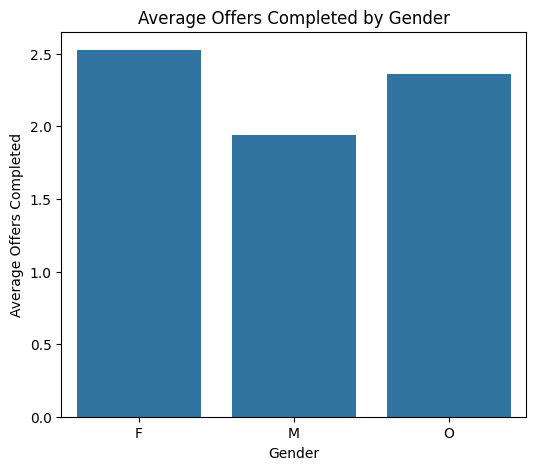

/var/folders/_r/vrv2ggns7ls64mbsxn00sq_h0000gn/T/ipykernel_76927/2948496997.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_completion_by_age = profile_features.groupby('age_group')['offers_completed'].mean().reset_index()


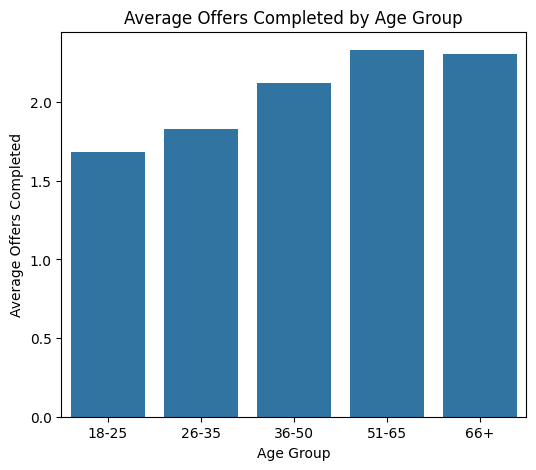

/var/folders/_r/vrv2ggns7ls64mbsxn00sq_h0000gn/T/ipykernel_76927/2948496997.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_completion_by_income = profile_features.groupby('income_group')['offers_completed'].mean().reset_index()


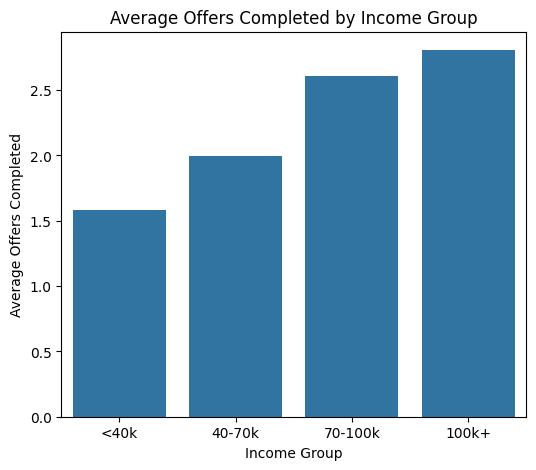

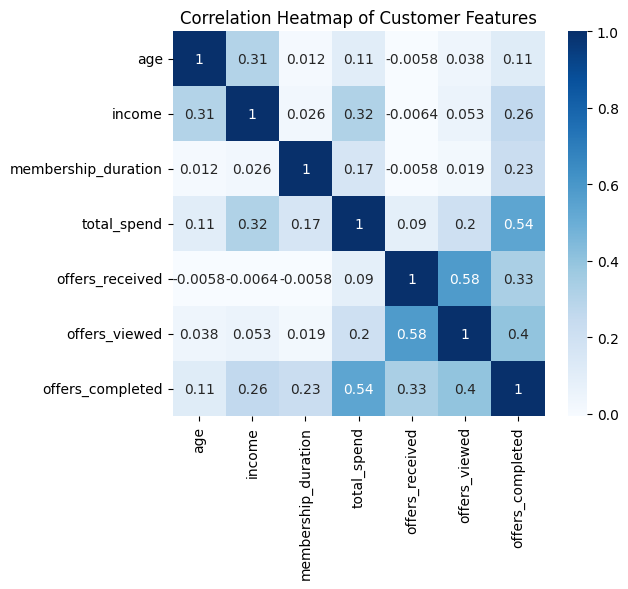

In [20]:
# 1. Offer completion rate by gender
offer_completion_by_gender = profile_features.groupby('gender')['offers_completed'].mean().reset_index()
plt.figure(figsize=(6,5))
sns.barplot(x='gender', y='offers_completed', data=offer_completion_by_gender)
plt.title('Average Offers Completed by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Offers Completed')
plt.savefig(f'plots/ave_offers_genda_group.png', bbox_inches='tight')
plt.show()

# 2. Offer completion rate by age group
profile_features['age_group'] = pd.cut(profile_features['age'], bins=[17, 25, 35, 50, 65, 120], labels=['18-25', '26-35', '36-50', '51-65', '66+'])
offer_completion_by_age = profile_features.groupby('age_group')['offers_completed'].mean().reset_index()
plt.figure(figsize=(6,5))
sns.barplot(x='age_group', y='offers_completed', data=offer_completion_by_age)
plt.title('Average Offers Completed by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Offers Completed')
plt.savefig(f'plots/ave_offers_age_group.png', bbox_inches='tight')
plt.show()

# 3. Offer completion rate by income group
profile_features['income_group'] = pd.cut(profile_features['income'], bins=[0, 40000, 70000, 100000, 130000], labels=['<40k', '40-70k', '70-100k', '100k+'])
offer_completion_by_income = profile_features.groupby('income_group')['offers_completed'].mean().reset_index()
plt.figure(figsize=(6,5))
sns.barplot(x='income_group', y='offers_completed', data=offer_completion_by_income)
plt.title('Average Offers Completed by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Average Offers Completed')
plt.savefig(f'plots/ave_offers_income_group.png', bbox_inches='tight')
plt.show()

# 4. Correlation heatmap for numerical features
plt.figure(figsize=(6,5))
sns.heatmap(profile_features[['age', 'income', 'membership_duration', 'total_spend', 'offers_received', 'offers_viewed', 'offers_completed']].corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap of Customer Features')
plt.savefig(f'plots/correlation_heatmap.png', bbox_inches='tight')
plt.show()

# Predictive Modeling

Now that we have engineered features and explored the data, we can build predictive models to answer key business questions. Two common targets are:

- **Predicting Offer Completion:**  
  Classify whether a customer will complete an offer based on their demographics and engagement.

- **Predicting Total Spend:**  
  Regress the total amount a customer will spend, which can help target high-value customers.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score

# --- Classification: Predict if a customer completes at least one offer ---

# Create binary target: 1 if offers_completed > 0, else 0
profile_features['completed_offer'] = (profile_features['offers_completed'] > 0).astype(int)

# Select features and target
features = ['age', 'income', 'membership_duration', 'offers_received', 'offers_viewed']
X = profile_features[features]
y = profile_features['completed_offer']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report (Offer Completion):")
print(classification_report(y_test, y_pred))

# --- Regression: Predict total spend ---

y_reg = profile_features['total_spend']

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Train regressor
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

# Regression metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("Regression Results (Total Spend):")
print("RMSE:", rmse)
print("R^2 Score:", r2_score(y_test_reg, y_pred_reg))

Classification Report (Offer Completion):
              precision    recall  f1-score   support

           0       0.52      0.31      0.39       570
           1       0.85      0.93      0.89      2395

    accuracy                           0.81      2965
   macro avg       0.69      0.62      0.64      2965
weighted avg       0.79      0.81      0.79      2965

Regression Results (Total Spend):
RMSE: 122.06398545315861
R^2 Score: 0.14516842828427245


### Model Results Interpretation

#### Classification: Predicting Offer Completion

- **Accuracy:** 81%  
  The model correctly predicts whether a customer will complete an offer 81% of the time.

- **Class 0 (Did Not Complete Offer):**
  - **Precision:** 0.52  
    When the model predicts a customer will not complete an offer, it is correct 52% of the time.
  - **Recall:** 0.31  
    Only 31% of customers who did not complete an offer are correctly identified.

- **Class 1 (Completed Offer):**
  - **Precision:** 0.85  
    When the model predicts a customer will complete an offer, it is correct 85% of the time.
  - **Recall:** 0.93  
    93% of customers who completed an offer are correctly identified.

- **Imbalance:**  
  The model is much better at identifying customers who complete offers than those who do not. This suggests a class imbalance, with more customers completing offers than not.

**Business Implication:**  
If the goal is to target likely responders, the model is effective. However, if it is important to avoid sending offers to non-responders, further work is needed (e.g., balancing classes or adjusting thresholds).

---

#### Regression: Predicting Total Spend

- **RMSE:** 122.06  
  On average, the model's predictions are off by about $122.

- **R² Score:** 0.15  
  The model explains only 15% of the variance in total spend, indicating limited predictive power.

**Business Implication:**  
Current features do not sufficiently explain customer spending. Additional feature engineering or alternative modeling approaches may be needed to improve performance.

---

### Next Steps

- For classification: Address class imbalance, tune hyperparameters, or try different algorithms.
- For regression: Engineer more features, try advanced models, or accept that spend is influenced by factors not captured in the data.
- Use feature importance analysis to understand which variables drive predictions and inform business strategies.

membership_duration    0.388371
income                 0.242658
age                    0.222375
offers_viewed          0.082659
offers_received        0.063937
dtype: float64


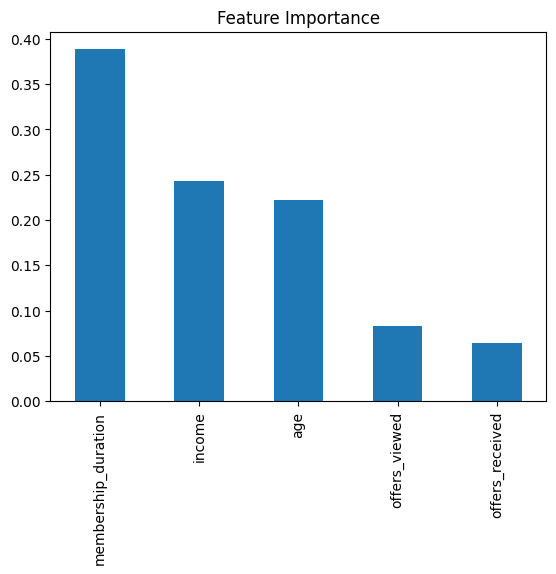

In [23]:
importances = clf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print(feature_importance)
feature_importance.plot(kind='bar', title='Feature Importance')
plt.savefig(f'plots/importance.png', bbox_inches='tight')
plt.show()

/var/folders/_r/vrv2ggns7ls64mbsxn00sq_h0000gn/T/ipykernel_76927/3830044151.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_by_bucket = profile_features.groupby('membership_bucket')['offers_completed'].mean().reset_index()


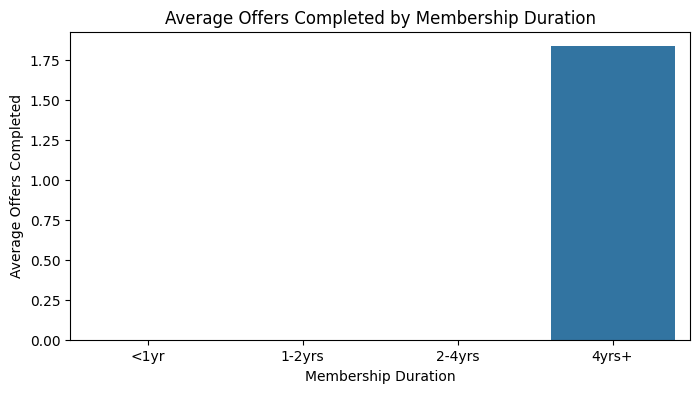

In [24]:
# Visualize offer completion rate by membership duration buckets
profile_features['membership_bucket'] = pd.cut(
    profile_features['membership_duration'],
    bins=[0, 365, 730, 1460, 3000],
    labels=['<1yr', '1-2yrs', '2-4yrs', '4yrs+']
)
completion_by_bucket = profile_features.groupby('membership_bucket')['offers_completed'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='membership_bucket', y='offers_completed', data=completion_by_bucket)
plt.title('Average Offers Completed by Membership Duration')
plt.xlabel('Membership Duration')
plt.ylabel('Average Offers Completed')
plt.savefig(f'plots/membership_duration_completion.png', bbox_inches='tight')
plt.show()

**Insight:**  
Customers with a membership duration of **4 years or more** ("4yrs+") have the highest average offer completion rate. This suggests that long-term, loyal customers are much more likely to engage with and complete offers compared to newer members.

**Business Recommendation:**  
- Focus marketing and offer campaigns on long-term members to maximize response rates.
- Consider special loyalty rewards or exclusive offers for customers with 4+ years of membership to further increase engagement and retention.
- For newer members, explore onboarding or engagement strategies to help them become more active over time.

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [25]:
# Use the best parameters found by GridSearchCV to train a new RandomForestClassifier
best_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)
best_clf.fit(X_train, y_train)
y_pred_best = best_clf.predict(X_test)

# Evaluate the optimized model
print("Classification Report (Optimized Random Forest):")
print(classification_report(y_test, y_pred_best))

Classification Report (Optimized Random Forest):
              precision    recall  f1-score   support

           0       0.52      0.27      0.36       570
           1       0.84      0.94      0.89      2395

    accuracy                           0.81      2965
   macro avg       0.68      0.61      0.62      2965
weighted avg       0.78      0.81      0.79      2965



### Classification Report (Optimized Random Forest)

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0 (Did Not Complete Offer) | 0.52 | 0.27 | 0.36 | 570 |
| 1 (Completed Offer)        | 0.84 | 0.94 | 0.89 | 2395 |

- **Accuracy:** 0.81 (81%)
- **Macro avg:** Precision 0.68, Recall 0.61, F1-score 0.62
- **Weighted avg:** Precision 0.78, Recall 0.81, F1-score 0.79

**Interpretation:**
- The model is very good at identifying customers who complete offers (high recall for class 1).
- It struggles to identify non-responders (class 0), with low recall (0.27).
- Overall accuracy is high, but the class imbalance issue persists.

# Segment Customers for Targeted Marketing

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering
segmentation_features = ['age', 'income', 'membership_duration', 'total_spend', 'offers_received', 'offers_viewed', 'offers_completed']
X_seg = profile_features[segmentation_features]

# Fill any missing values (should be none after previous cleaning)
X_seg = X_seg.fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
profile_features['customer_segment'] = kmeans.fit_predict(X_scaled)

# Analyze the segments
segment_summary = profile_features.groupby('customer_segment')[segmentation_features].mean()
display(segment_summary)

,age,income,membership_duration,total_spend,offers_received,offers_viewed,offers_completed
customer_segment,,,,,,,
0,59.669267,77026.874729,3026.770264,219.242274,5.125271,4.262245,3.809926
1,48.097505,53616.451017,3681.450092,90.348595,4.480591,3.246303,2.177449
2,60.560503,73238.186288,2896.810707,95.409683,3.306200,2.175908,1.515160
3,46.802326,52456.908345,2692.949384,40.708924,4.800046,3.466256,1.050160


## Customer Segmentation Summary

| Segment | Avg Age | Avg Income | Avg Membership Duration (days) | Avg Total Spend | Avg Offers Received | Avg Offers Viewed | Avg Offers Completed |
|---------|---------|------------|-------------------------------|-----------------|--------------------|-------------------|---------------------|
| **0**   | 59.7    | $77,027    | 3,027                         | $219.24         | 5.13               | 4.26              | 3.81                |
| **1**   | 48.1    | $53,616    | 3,681                         | $90.35          | 4.48               | 3.25              | 2.18                |
| **2**   | 60.6    | $73,238    | 2,897                         | $95.41          | 3.31               | 2.18              | 1.52                |
| **3**   | 46.8    | $52,457    | 2,693                         | $40.71          | 4.80               | 3.47              | 1.05                |

**Interpretation & Targeting Recommendations:**

- **Segment 0:**  
  Older, higher-income, long-tenured customers with the highest spend and offer engagement.  
  *Target with premium offers, loyalty rewards, and exclusive deals.*

- **Segment 1:**  
  Middle-aged, moderate-income, longest-tenured customers with moderate spend and engagement.  
  *Target with retention campaigns and personalized offers to increase spend.*

- **Segment 2:**  
  Older, higher-income, shorter-tenured customers with lower spend and engagement.  
  *Target with onboarding and engagement strategies to boost activity.*

- **Segment 3:**  
  Younger, lower-income, shortest-tenured customers with the lowest spend and engagement.  
  *Target with introductory offers, discounts, and educational content to increase engagement.*

Use these segments to tailor marketing strategies and maximize offer effectiveness for each group.

# Conclusion

In this project, we analysed customer behaviour on the Starbucks Rewards mobile app using simulated data. Through comprehensive data cleaning, exploratory analysis, feature engineering, predictive modelling, and customer segmentation, we uncovered key insights into how different demographic groups engage with offers.

**Key findings:**
- Long-tenured, higher-income customers are the most engaged and have the highest spend, making them ideal targets for premium and loyalty offers.
- Younger and lower-income customers show lower engagement and spend, suggesting a need for introductory offers and engagement strategies.
- The classification model effectively predicts offer responders, though further work is needed to better identify non-responders due to class imbalance.
- Regression models for total spend have limited predictive power, indicating that additional features or alternative approaches may be required.

**Business recommendations:**
- Focus marketing efforts on long-term, high-value customers with exclusive and loyalty-based offers.
- Develop onboarding and engagement campaigns for newer and lower-engagement segments.
- Continuously monitor and refine segmentation and targeting strategies as more data becomes available.

This analysis provides a strong foundation for data-driven marketing at Starbucks and demonstrates how customer data can be leveraged to optimise offer targeting and maximise business value.